In [1]:
#Activation of the libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import openseespy.opensees as ops
import opsvis as opsv
import time

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 0.00670595 (max: 1e-06)
	Norm deltaX: 0.0118714, Norm R: 1.14713
	deltaX: -0.00054594 -0.0118588 
	deltaR: -0.25056 -1.11943 
CTestEnergyIncr::test() - iteration: 2 current EnergyIncr: 0.000171043 (max: 1e-06)
	Norm deltaX: 0.00189395, Norm R: 0.189173
	deltaX: 6.21516e-05 -0.00189293 
	deltaR: -0.0502786 -0.182369 
CTestEnergyIncr::test() - iteration: 3 current EnergyIncr: 4.54964e-06 (max: 1e-06)
	Norm deltaX: 0.000305255, Norm R: 0.0307691
	deltaX: 6.32043e-07 -0.000305254 
	deltaR: -0.00756547 -0.0298245 
CTestEnergyIncr::test() - iteration: 4 current EnergyIncr: 1.21619e-07 (max: 1e-06)
	Norm deltaX: 5.00554e-05, Norm R: 0.00504461
	deltaX: 7.48734e-07 -5.00498e-05 
	deltaR: -0.00128169 -0.00487907 

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 0.0204014 (max: 1e-06)
	Norm deltaX: 0.0140652, Norm R: 2.92274
	deltaX: -0.00132557 -0.0140026 
	deltaR: -0.627704 -2.85453 
CTestEnergyIncr::test() - iteration: 2 cu

[[ 0.00000000e+00  0.00000000e+00]
 [ 2.50886417e-02  6.05567347e+01]
 [ 4.81912507e-02  1.13501488e+02]
 [ 6.63066228e-02  1.52519741e+02]
 [ 7.49611996e-02  1.74799886e+02]
 [ 7.19344453e-02  1.92496450e+02]
 [ 5.79683330e-02  2.22834105e+02]
 [ 3.67624200e-02  2.69848641e+02]
 [ 1.24166988e-02  3.27298716e+02]
 [-1.31154178e-02  3.90208528e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4.56154233e+02]
 [-3.91015676e-02  4

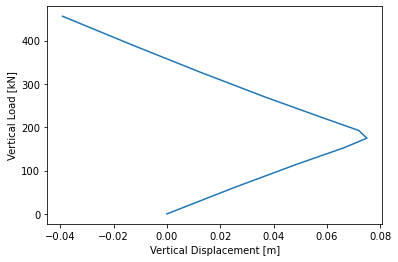

Running Time:  1.6057384014129639  seconds


In [2]:
# Define the model
ops.wipe()
start = time.time()
### model('basic', '-ndm', ndm, '-ndf', ndf=ndm*(ndm+1)/2)
ops.model('basic', '-ndm', 2, '-ndf', 2)


ArcLengthAlpha = 0.30 #Initial value of alpha (arc length parameter)
ArcLengthLambda = 0.12  #Initial value of lambda (arc length parameter)
spring_stiffness = 178.807


#Geometric and material properties
E1 = 200000  # Modulus of elasticity in kN/m^2
A1 = 0.01  # Area of the section in m^2
E2 = 100000  # Modulus of elasticity in kN/m^2
A2 = 0.01 # Area of the section in m^2

# Load parameters
Px = 0
Py = 30 #kN

#Coordinates of the nodes
Lhalf = 2.1
L = 2*Lhalf
### node(nodeTag, *crds, '-ndf', ndf, '-mass', *mass, '-disp', *disp, '-vel', *vel, '-accel', *accel)
ops.node(1, 0.0, 0.0)
ops.node(2, Lhalf, 1.0) 
ops.node(3, Lhalf, 1.0)
ops.node(4, L, 0.0)


# Define boundary conditions (first and third nodes are free restrained)
### fix(nodeTag, *constrValues)
ops.fix(1, 1, 1)
ops.fix(3, 1, 1)
ops.fix(4, 1, 1)

# Define material
### uniaxialMaterial(matType, matTag, *matArgs)
ops.uniaxialMaterial('Elastic', 1, E1)
ops.uniaxialMaterial('Elastic', 2, E2)

# Spring stiffness in kN/m
 
ops.uniaxialMaterial('Elastic', 3, spring_stiffness)

# Define elements using corotTruss element (accounts for geometric nonlinearity)
### element(eleType, eleTag, *eleNodes, *eleArgs)
ops.element('corotTruss', 1, 1, 2, A1, 1)
ops.element('corotTruss', 2, 2, 4, A2, 2)
ops.element('zeroLength', 3, 3, 2, '-mat', 3, '-dir', 2)

# Define load at the middle node
### timeSeries(tsType, tsTag, *tsArgs)
ops.timeSeries('Linear', 1)
### pattern(patternType, patternTag, *patternArgs)
ops.pattern('Plain', 1, 1)

#Load
###load(nodeTag, *loadValues)
ops.load(2, 0, -Py)

# create SOE - System Of Equation
### system(systemType, *systemArgs)
ops.system('ProfileSPD')

# create DOF number
### numberer(numbererType, *numbererArgs)
ops.numberer('RCM')

# create constraint handler
### constraints(constraintType, *constraintArgs)
ops.constraints('Plain')

# create integrator
Nsteps=50 #Number of increments

ops.integrator('ArcLength', ArcLengthAlpha, ArcLengthLambda) 

# create algorithm
### algorithm(algoType, *algoArgs)
ops.algorithm('ModifiedNewton', '-initial') #MODIFIED NEWTON-RAPHSON!

# create test
### test(testType, *testArgs)
ops.test('EnergyIncr', 1.0e-6, 30, 4)

# create analysis object
### analysis(analysisType)
ops.analysis("Static")

#PERFORM ANALYSIS
data = np.zeros((Nsteps+1,2)) 
for j in range(Nsteps):
    ### analyze(numIncr=1, dt=0.0, dtMin=0.0, dtMax=0.0, Jd=0)
    ops.analyze(1) 
    data[j+1,0] = ops.nodeDisp(2,1)    #abs(ops.nodeDisp(2,2))
    data[j+1,1] = ops.getLoadFactor(1)*Py 
print(data)
results = pd.DataFrame(data, columns=['Displacement','Force'])
results.to_excel('Results - Arclength Method - RIKS AND WAMPNER.xlsx')

plt.plot(data[:,0], data[:,1])
plt.xlabel('Vertical Displacement [m]')
#plt.ylim(-30, 100)
plt.ylabel('Vertical Load [kN]')
plt.show()

end = time.time()
running_time = (end - start)
print('Running Time: ', running_time, ' seconds')